# Pendahuluan

# Import Library

In [ ]:
!pip install yahoofinancials
from yahoofinancials import YahooFinancials
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from datetime import datetime

#For reproducability
from numpy.random import seed
seed(1)



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<ipython-input-2-2228fd32b7e9>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Get Data

In [ ]:
# buat function 
def plot_predictions(test,predicted,symbol):
    plt.plot(test, color='red',label=f'Real {symbol} Stock Price')
    plt.plot(predicted, color='blue',label=f'Predicted {symbol} Stock Price')
    plt.title(f'{symbol} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{symbol} Stock Price')
    plt.legend()
    plt.show()

def plot_return_predictions(test,predicted,symbol):
    plt.plot(test, color='red',label=f'Real {symbol} Stock Price Returns')
    plt.plot(predicted, color='blue',label=f'Predicted {symbol} Stock Price Return')
    plt.title(f'{symbol} Stock Return Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{symbol} Stock Price Returns')
    plt.legend()
    plt.show()
    
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

def get_ticker_data(ticker: str, param_start_date, param_end_date) -> dict:
    raw_data = YahooFinancials(ticker)
    return raw_data.get_historical_price_data(param_start_date, param_end_date, "daily").copy()

def fetch_ticker_data(ticker: str, start_date, end_date) -> pd.DataFrame:
    date_range = pd.bdate_range(start=start_date, end=end_date)
    values = pd.DataFrame({'Date': date_range})
    values['Date'] = pd.to_datetime(values['Date'])
    raw_data = get_ticker_data(ticker, start_date, end_date)
    return pd.DataFrame(raw_data[ticker]["prices"])[['date', 'open', 'high', 'low', 'adjclose', 'volume']]

def shift(xs, n):
    e = np.empty_like(xs)
    if n >= 0:
        e[:n] = np.nan
        e[n:] = xs[:-n]
    else:
        e[n:] = np.nan
        e[:n] = xs[-n:]
    return e



In [ ]:
# # Choose a stock symbol
symbol_to_fetch = 'BBRI.JK'

# Choose a date range
start_date = '2012-01-01'
end_date = '2022-12-31'

# Get Stock Price Data
stock = fetch_ticker_data(symbol_to_fetch, start_date, end_date)
stock.columns = ['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume']
stock['DateTime'] = stock['DateTime'].apply(lambda x: datetime.fromtimestamp(x))
stock = stock.fillna(method="ffill", axis=0)
stock = stock.fillna(method="bfill", axis=0)
stock = stock.set_index('DateTime')

stock['Symbol'] = symbol_to_fetch
stock.tail()

#save a copy for later testing
original_stock = stock
original_symbol = symbol_to_fetch
# show dataset
stock['Close'].tail()

DateTime
2022-12-26 02:00:00    4639.029297
2022-12-27 02:00:00    4582.570801
2022-12-28 02:00:00    4535.521973
2022-12-29 02:00:00    4582.570801
2022-12-30 02:00:00    4648.439453
Name: Close, dtype: float64

In [ ]:
# Choose a stock symbol
symbol_to_fetch = 'BBRI.JK'
# Choose a date range
start_date = str(datetime(2012, 1, 1).date())
end_date = str(datetime(2021, 12, 31).date())
# end_date = datetime.now().strftime('%Y-%m-%d')

# Modelling

In [ ]:

def single_exponential_smoothing(train_data, alpha):
    '''
    Single Exponential Smoothing (SES) function to forecast the test data

    Parameters:
        train_data (array): Array of training data
        alpha (float): Smoothing factor (0 < alpha < 1)

    Returns:
        smoothed_data (array): Array of smoothed data
    '''
    smoothed_data = [train_data[0]]  # Set the first value equal to the first data point in train data
    for i in range(1, len(train_data)):
        smoothed_data.append(alpha * train_data[i] + (1 - alpha) * smoothed_data[i-1])
    return smoothed_data

In [ ]:
# Load stock price data from a CSV file
stock_price_data = stock.copy()

In [ ]:
def single_exponential_smoothing(train_data, alpha):
    '''
    Single Exponential Smoothing (SES) function to forecast the test data

    Parameters:
        train_data (array): Array of training data
        alpha (float): Smoothing factor (0 < alpha < 1)

    Returns:
        smoothed_data (array): Array of smoothed data
    '''
    smoothed_data = [train_data[0]]  # Set the first value equal to the first data point in train data
    for i in range(1, len(train_data)):
        smoothed_data.append(alpha * train_data[i] + (1 - alpha) * smoothed_data[i-1])
    return smoothed_data

def MAPE(actual, predicted):
    '''
    Mean Absolute Percentage Error (MAPE) function

    Parameters:
        actual (array): Array of actual values
        predicted (array): Array of predicted values

    Returns:
        mape (float): MAPE value
    '''
    return np.mean(np.abs((actual - predicted) / actual)) * 100


In [ ]:
# Split data into train and test sets
train_data = stock_price_data['Close'][:-273].values
test_data = stock_price_data['Close'][2461:].values

In [ ]:
# Apply Single Exponential Smoothing to training data
alpha = 1  # Smoothing factor
smoothed_data = single_exponential_smoothing(train_data, alpha)


# Evaluasi

MAPE of the forecast: 11.15%


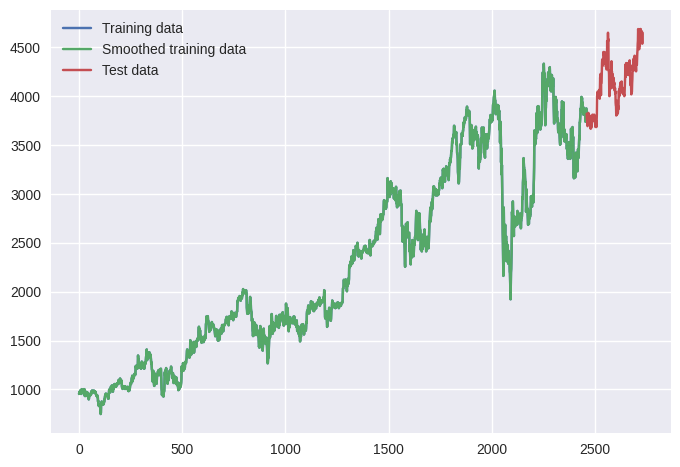

In [ ]:
# Compute MAPE of the forecast
mape = MAPE(test_data, smoothed_data[-len(test_data):])
print(f'MAPE of the forecast: {mape:.2f}%')

# Plot the original training data, smoothed training data, and test data
plt.plot(train_data, label='Training data')
plt.plot(smoothed_data, label='Smoothed training data')
plt.plot(np.arange(len(train_data), len(train_data)+len(test_data)), test_data, label='Test data')
plt.legend()
plt.show()
